In [1]:
# Load model directly
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, Seq2SeqTrainingArguments, Seq2SeqTrainer

tokenizer = AutoTokenizer.from_pretrained("Falconsai/text_summarization")
model = AutoModelForSeq2SeqLM.from_pretrained("Falconsai/text_summarization")

In [2]:
import pandas as pd
import datasets
from sklearn.model_selection import train_test_split

file_name = '../data/processed/summarized_insights.csv'

dataset = datasets.load_dataset("csv", data_files=file_name)


In [3]:
def preprocess_function(examples):
    inputs = [doc for doc in examples["Combined Comments"]]
    model_inputs = tokenizer(inputs, max_length=512, padding="max_length", truncation=True)

    # Setup the tokenizer for targets
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(examples["Summary"], max_length=128, padding="max_length", truncation=True)

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

tokenized_datasets = dataset.map(preprocess_function, batched=True)

In [4]:
# Split the tokenized dataset into training and temp datasets (70% training, 30% temp)
train_dataset, temp_dataset = tokenized_datasets['train'].train_test_split(test_size=0.3).values()

# Split the temp dataset into evaluation and test datasets (50% evaluation, 50% test)
eval_dataset, test_dataset = temp_dataset.train_test_split(test_size=0.5).values()

In [10]:
training_args = Seq2SeqTrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    weight_decay=0.01,
    save_total_limit=3,
    num_train_epochs=8,
    predict_with_generate=True,
)


  0%|          | 0/1800 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

{'eval_loss': 2.3873629570007324, 'eval_runtime': 1.9832, 'eval_samples_per_second': 68.071, 'eval_steps_per_second': 17.144, 'epoch': 1.0}


  0%|          | 0/34 [00:00<?, ?it/s]

{'eval_loss': 2.3538718223571777, 'eval_runtime': 1.996, 'eval_samples_per_second': 67.637, 'eval_steps_per_second': 17.034, 'epoch': 2.0}
{'loss': 2.5798, 'learning_rate': 1.4444444444444446e-05, 'epoch': 2.22}


  0%|          | 0/34 [00:00<?, ?it/s]

{'eval_loss': 2.3295717239379883, 'eval_runtime': 1.9548, 'eval_samples_per_second': 69.061, 'eval_steps_per_second': 17.393, 'epoch': 3.0}


  0%|          | 0/34 [00:00<?, ?it/s]

{'eval_loss': 2.30973219871521, 'eval_runtime': 1.9892, 'eval_samples_per_second': 67.866, 'eval_steps_per_second': 17.092, 'epoch': 4.0}
{'loss': 2.5354, 'learning_rate': 8.888888888888888e-06, 'epoch': 4.44}


  0%|          | 0/34 [00:00<?, ?it/s]

{'eval_loss': 2.294679641723633, 'eval_runtime': 1.9817, 'eval_samples_per_second': 68.125, 'eval_steps_per_second': 17.157, 'epoch': 5.0}


  0%|          | 0/34 [00:00<?, ?it/s]

{'eval_loss': 2.284925699234009, 'eval_runtime': 2.0162, 'eval_samples_per_second': 66.956, 'eval_steps_per_second': 16.863, 'epoch': 6.0}
{'loss': 2.4945, 'learning_rate': 3.3333333333333333e-06, 'epoch': 6.67}


  0%|          | 0/34 [00:00<?, ?it/s]

{'eval_loss': 2.2790894508361816, 'eval_runtime': 2.0083, 'eval_samples_per_second': 67.222, 'eval_steps_per_second': 16.93, 'epoch': 7.0}


  0%|          | 0/34 [00:00<?, ?it/s]

{'eval_loss': 2.2770018577575684, 'eval_runtime': 2.0116, 'eval_samples_per_second': 67.11, 'eval_steps_per_second': 16.902, 'epoch': 8.0}
{'train_runtime': 606.224, 'train_samples_per_second': 11.877, 'train_steps_per_second': 2.969, 'train_loss': 2.5305128987630208, 'epoch': 8.0}


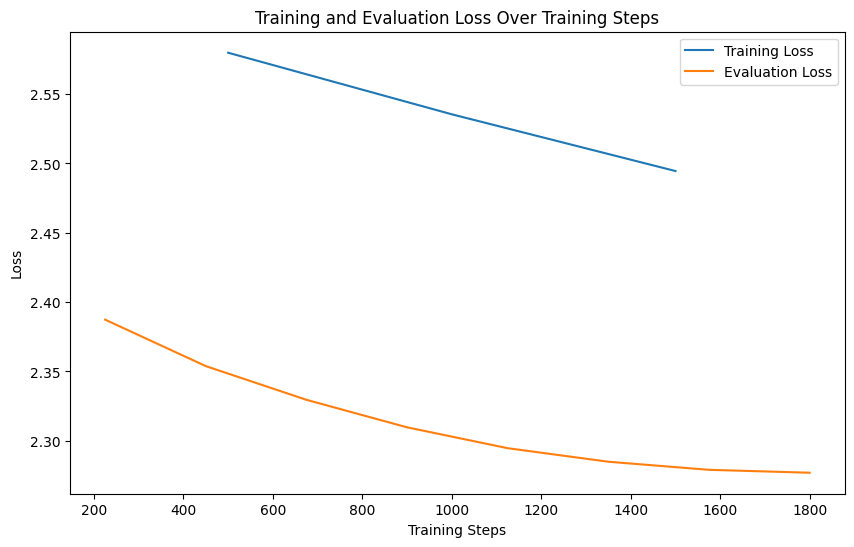

In [18]:
import pandas as pd
import matplotlib.pyplot as plt

# Your training code
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets['train'],
    tokenizer=tokenizer,
    eval_dataset=eval_dataset
)

trainer.train()

# Extracting loss values from the log history
log_history = trainer.state.log_history
df_logs = pd.DataFrame(log_history)

# Filtering out rows with loss values
train_logs = df_logs[df_logs['loss'].notnull()]
eval_logs = df_logs[df_logs['eval_loss'].notnull()]

# Plotting the loss curves
plt.figure(figsize=(10, 6))
plt.plot(train_logs['step'], train_logs['loss'], label='Training Loss')
plt.plot(eval_logs['step'], eval_logs['eval_loss'], label='Evaluation Loss')
plt.title('Training and Evaluation Loss Over Training Steps')
plt.xlabel('Training Steps')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [12]:
pd.DataFrame(trainer.state.log_history)


,eval_loss,eval_runtime,eval_samples_per_second,eval_steps_per_second,epoch,step,loss,learning_rate,train_runtime,train_samples_per_second,train_steps_per_second,total_flos,train_loss
0,2.664816,1.9657,68.678,17.297,1.00,225,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2.574870,1.9990,67.533,17.008,2.00,450,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,2.22,500,2.9342,0.000014,NaN,NaN,NaN,NaN,NaN
3,2.519457,2.0087,67.208,16.926,3.00,675,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2.482509,2.2050,61.225,15.420,4.00,900,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,4.44,1000,2.7523,0.000009,NaN,NaN,NaN,NaN,NaN
6,2.456422,2.5104,53.776,13.544,5.00,1125,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,2.440261,2.0037,67.377,16.969,6.00,1350,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,6.67,1500,2.6644,0.000003,NaN,NaN,NaN,NaN,NaN
9,2.430324,2.0081,67.228,16.932,7.00,1575,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
example = eval_dataset[1]
inputs = tokenizer(example["Combined Comments"], return_tensors="pt", padding=True, truncation=True, max_length=512)
outputs = model.generate(input_ids=inputs["input_ids"].to(model.device), attention_mask=inputs["attention_mask"].to(model.device), max_length=128)
prediction = tokenizer.decode(outputs[0], skip_special_tokens=True)

print(prediction)

- Address the issue of a mild heat to ensure that the spices are not too spicy for the customer. - Address the issue of kottu, a small side & soda, as it is not recommended for those looking for Sri Lankan kottu. - Address the issue of a lack of water to avoid a stale taste. - Address the issue of a lack of water to avoid a stale taste. - Address the issue of kottu, as it is not recommended for those looking for a sprinkling.


In [15]:
! pip install tabulate


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [14]:
print(prediction)
print(example["Combined Comments"])

- Address the issue of a mild heat to ensure that the spices are not too spicy for the customer. - Address the issue of kottu, a small side & soda, as it is not recommended for those looking for Sri Lankan kottu. - Address the issue of a lack of water to avoid a stale taste. - Address the issue of a lack of water to avoid a stale taste. - Address the issue of kottu, as it is not recommended for those looking for a sprinkling.
Not for those that don't take spices, as myself. Even with the very mild heat that was requested, it was still too spicy for me. But good value for lunch. Comes w/ a small box of kottu, a small side & soda. // Idk if it was just me but the lentil patties are so exceedingly dry I could barely choke down one without reaching for water. // I don't know what I just ate, but it was really bad. // Spies tasted too raw and dry. Not recommended for those looking for Sri Lankan kottu. Coffee flan looks like Cat Food.


In [17]:
from tabulate import tabulate

# Loop through the first three items of the eval_dataset
for i in range(1, 4):
    example = eval_dataset[i]
    inputs = tokenizer(example["Combined Comments"], return_tensors="pt", padding=True, truncation=True, max_length=512)
    outputs = model.generate(input_ids=inputs["input_ids"].to(model.device), attention_mask=inputs["attention_mask"].to(model.device), max_length=128)
    prediction = tokenizer.decode(outputs[0], skip_special_tokens=True)

    # Preparing data for the table
    headers = ["Field", "Value"]
    data = [
        ["Combined Comments", example["Combined Comments"]],
        ["Prediction", prediction]
    ]

    # Print the table with wrapping lines
    print(f"Example {i}:")
    print(tabulate(data, headers=headers, tablefmt="grid"))
    print("\n")  # Add a newline for better separation between examples


Example 1:
+-------------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Field             | Value                                                                                                                                                                                                                                                                                                                                                                                                                                        